# Deep Learning for Computer Vision:  HW 2


## Computer Science: COMS W 4995 007


## Due: October 9, 2019

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu or leaky ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

e) Try choosing you own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisey as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 85%, e=10%, f=5%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,0.277192,0.741612,1.0
1,0.151180,-0.167443,0.0
2,-0.238032,0.183643,0.0
3,-0.139681,1.091662,1.0
4,-0.114060,1.002226,1.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

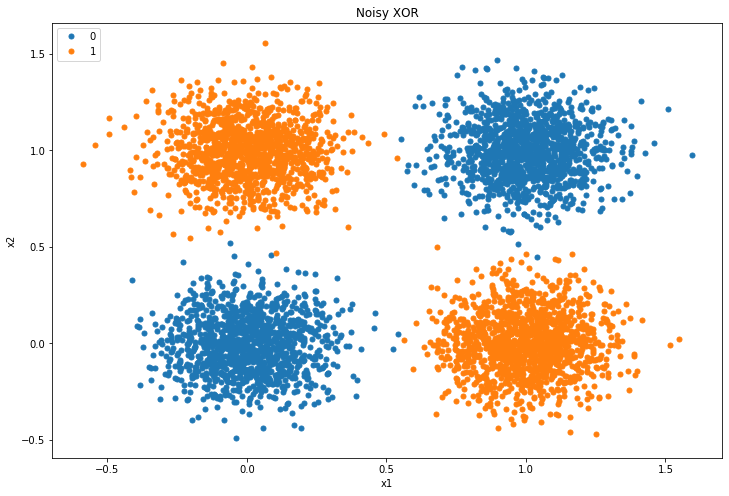

In [5]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

#### Parts a-d

In [6]:
# Forward Propogation functions
# Hidden layer output
def get_hidden_layer_output(input_matrix):
    h = np.zeros((input_matrix.shape[0], input_matrix.shape[1]))
    for i in range(h.shape[0]):
        for j in range(h.shape[1]):
            h[i, j] = max(0, input_matrix[i, j])
    return h

# W should be 2 by m matrix, where m is the number of units in the hidden layer
# x should be one data point of 2 by 1 and c is the bias of m by 1
# Output: m by 1 array
def get_first_layer_output(W, x, c):
    W_T = np.transpose(W)
    u_1 = np.matmul(W_T, x)
    u_2 = u_1 + c
    return u_2

# Input h: m by 1 array
# Weights w: m by 1 array 
# Bias b: scalar
# Output: Scalar value
def get_last_layer_output(w, h, b):
    w_T = np.transpose(w)
    u_3 = np.matmul(w_T, h)
    z = u_3 + b
    return z

def get_loss_layer_output(y, z):
    softplus_input = (1 - 2*y)*z
    loss = np.log10(1 + np.exp(softplus_input))
    return [softplus_input, loss]

In [7]:
# Backpropogation functions
def get_loss_layer_deriv(softplus_input):
    loss_layer_deriv = 1/(1 + np.exp(-1 * softplus_input))
    return loss_layer_deriv

# Partial derivative of loss layer wrt z = partial derivative of loss layer wrt to b
def get_last_layer_deriv(loss_layer_deriv, y):
    partial_deriv_wrt_z = loss_layer_deriv*(1 - (2*y))
    return partial_deriv_wrt_z

# Scalar * (m by 1) array should return m by 1 array
def get_w_deriv(partial_deriv_wrt_z, h):
    partial_deriv_wrt_w = np.multiply(partial_deriv_wrt_z, h)
    return partial_deriv_wrt_w

# Scalar * (m by 1) array should return m by 1 array
def get_h_deriv(partial_deriv_wrt_z, w):
    partial_deriv_wrt_h = np.multiply(partial_deriv_wrt_z, w)
    return partial_deriv_wrt_h

# Should be (m by m) * (m by 1) proucing m by 1
def get_c_deriv(partial_deriv_wrt_h, u_2):
    f_u_2 = np.zeros((len(u_2), len(u_2)))
    for i in range(len(u_2)):
        if u_2[i] <= 0:
            f_u_2[i, i] = 0
        else:
            f_u_2[i, i] = 1
    partial_deriv_wrt_c = np.matmul(f_u_2.T, partial_deriv_wrt_h)
    return partial_deriv_wrt_c

# Should produce an 2 by m matrix at the end
def get_W_deriv(data_point, partial_deriv_wrt_c):
    partial_deriv_wrt_W = data_point * np.transpose(partial_deriv_wrt_c)
    return partial_deriv_wrt_W

In [8]:
# Forward and Backprop functions for binary cross entropy as a loss
def get_binary_cross_loss(y, z):
    probability = 1/(1 + np.exp(-1*z)) 
    loss = -y*np.log(probability) - (1-y)*np.log(1-probability)
    return [loss, probability]

def get_loss_derivative_cross(y, probability):
    partial_derivative_wrt_z = (-y/probability + (1-y)/(1-probability))*(probability)*(1-probability) +  0.000001
    return partial_derivative_wrt_z

In [9]:
# m = number of units in hidden layer
def train_mlp(m, use_cross_loss, lr, batch_size, iters, X, y, dim=2):
    m = m
    W = np.random.random((dim, m))
    w = np.random.random((m ,1))

    c = np.zeros((m, 1))
    b = 0
    loss_array = []
    for i in range(iters):
        # Try an iterative batch approach 
        W_avg = np.zeros((dim, m))
        w_avg = np.zeros((m ,1))

        c_avg = np.zeros((m, 1))
        b_avg = 0
        loss_avg = 0
        # This is gross I know but when I added the batch dimension, I had a lot of accuracy issues 
        # I apologize
        for j in range(batch_size):
            index = np.random.randint(0, len(X) - 1)
            data_point = np.array([X[index]]).T
            data_point = data_point.reshape(dim, 1)
            true_y = y[index]
         
            # Push data point through
            u_2 = get_first_layer_output(W, data_point, c)
            h = get_hidden_layer_output(u_2)
            z = get_last_layer_output(w, h, b)
            if use_cross_loss:
                [loss, probability] = get_binary_cross_loss(true_y, z)
                partial_deriv_wrt_z = get_loss_derivative_cross(true_y, probability)
            else:
                [softplus_input, loss] = get_loss_layer_output(true_y, z)
                loss_layer_deriv = get_loss_layer_deriv(softplus_input)
                partial_deriv_wrt_z = get_last_layer_deriv(loss_layer_deriv, true_y)
            
            # Equal to partial derivative wrt b
            partial_deriv_wrt_w = get_w_deriv(partial_deriv_wrt_z, h)
            partial_deriv_wrt_h = get_h_deriv(partial_deriv_wrt_z, w)
            partial_deriv_wrt_c = get_c_deriv(partial_deriv_wrt_h, u_2)
            partial_deriv_wrt_W = get_W_deriv(data_point, partial_deriv_wrt_c)
            
            W_avg = partial_deriv_wrt_W + W_avg
            w_avg = partial_deriv_wrt_w + w_avg
            c_avg = partial_deriv_wrt_c + c_avg
            b_avg = partial_deriv_wrt_z + b_avg
            
            # loss_sum = loss + loss_sum
            loss_avg = loss + loss_avg
        
        loss_array.append(loss_avg/batch_size)
        # Update weights and constants
        W = W - lr*(W_avg)/batch_size
        b = b - lr*(b_avg)/batch_size
        w = w - lr*(w_avg)/batch_size
        c = c - lr*(c_avg)/batch_size
    
    plt.plot(np.ravel(np.array(loss_array)))
    plt.show()
    
    values = {}
    values['W'] = W
    values['w'] = w
    values['b'] = b
    values['c'] = c
    return values

In [10]:
def plot_boundary(values):
    W = values['W']
    w = values['w']
    b = values['b']
    c = values['c']
    # Classify sample space
    num_points = 10000

    lower_bounds = [-0.5, -0.5]
    upper_bounds = [1.5, 1.5]

    # Sample data from uniformly with the given bounds
    data_points = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(num_points,2))
    class_1 = []
    class_2 = []

    for i in range(len(data_points)):
        data_point = np.array([data_points[i]])
        u_2 = get_first_layer_output(W, data_point.T, c)
        h = get_hidden_layer_output(u_2)
        z = get_last_layer_output(w, h, b)
        sig = 1/(1 + np.exp(-1*z))
        if sig >= 0.5:
            class_1.append(data_point)
        else:
            class_2.append(data_point)

    x_1, y_1 = np.array(class_1).T
    x_2, y_2 = np.array(class_2).T
    fig, axes = plt.subplots(figsize=(12,9))
    plt.scatter(x_1, y_1, c='b', label='class 1')
    plt.scatter(x_2, y_2, c='r', label='class 2')
    plt.show()

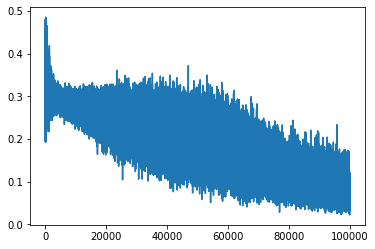

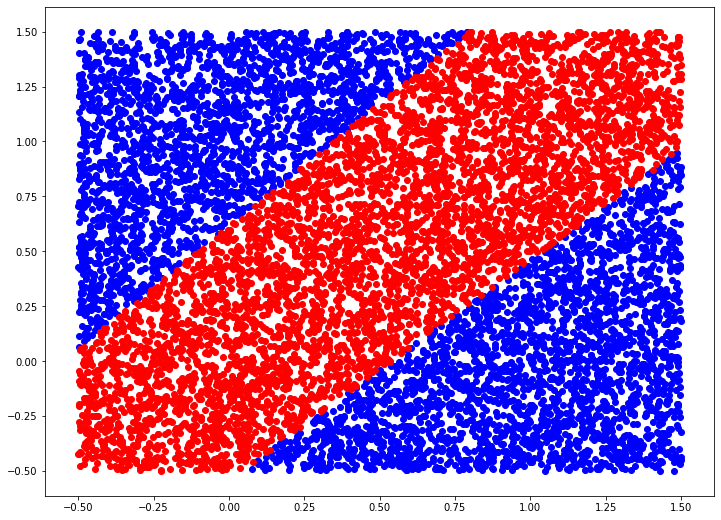

In [11]:
# For 2 neurons
values = train_mlp(m=2, use_cross_loss=False, iters=100000, batch_size=10, lr=0.001, X=X, y=y)
plot_boundary(values)

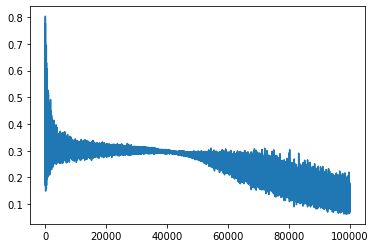

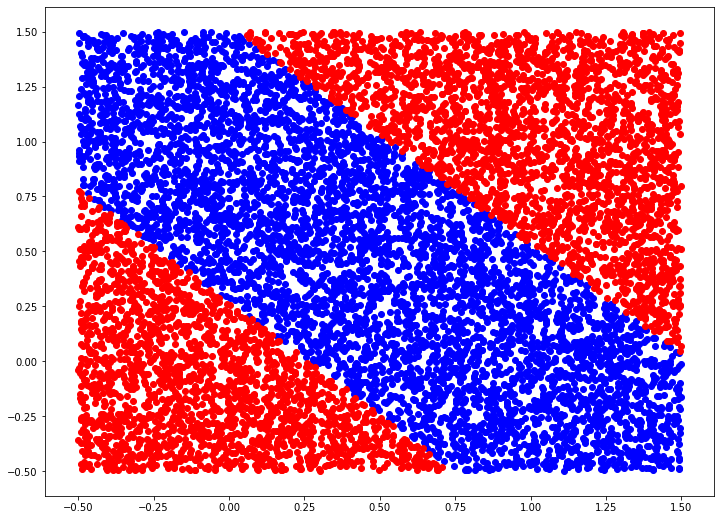

In [12]:
# For 3 neurons
values = train_mlp(m=3, use_cross_loss=False, iters=100000, batch_size=10, lr=0.001, X=X, y=y)
plot_boundary(values)

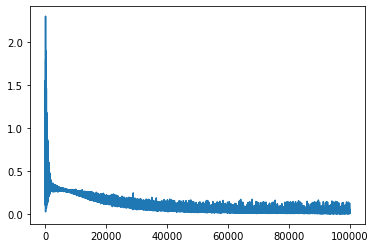

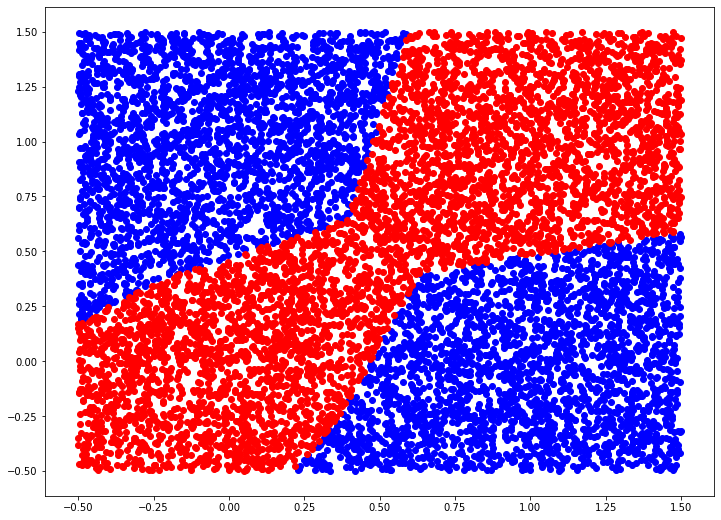

In [23]:
# For 16 neurons
values = train_mlp(m=16, use_cross_loss=False, iters=100000, batch_size=10, lr=0.001, X=X, y=y)
plot_boundary(values)

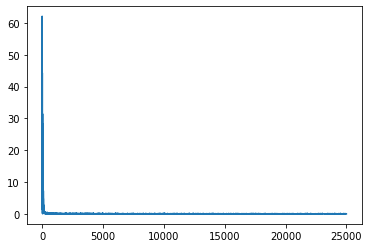

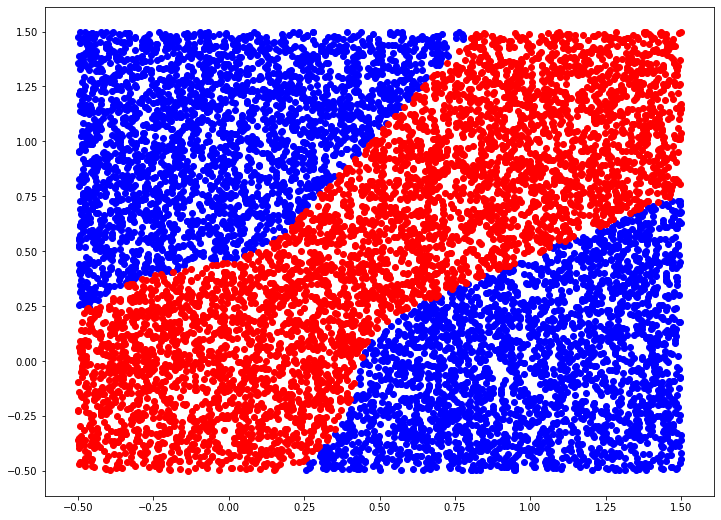

In [11]:
# For 512 neurons
values = train_mlp(m=512, use_cross_loss=False, iters=25000, batch_size=10, lr=0.01, X=X, y=y)
plot_boundary(values)

For increasing number of nodes, the boundaries improve in their separation of the classes. Specifically, when only 3 node are used, sometimes the decision boundaries are completely wrong however (seems like a random split of the feature split), on other instances of running the algorithm, the boundaries are determined with greater accuracy. These boundaries end up being completey linear and therefore, they separate the feature space somewhat accurately. By increasing to 16 nodes, the boundaries become more curved, improving in their accuracy in dividing the feature space, compared to 3 nodes. Finally, for 512, due to the very large size of the network, a different learning rate and fewer number of iterations are used, simply to account for the time it takes for the model to train on CPU. With that in mind, the output for 512 neurons is slightly more accurate than having 3 neurons but doesn't show any significant benefits over the network with a hidden layer consisting of 16 hidden units. While this may be an effect of the learning rate/number of iterations used, it could also be due to the network being very complex for a fairly simple problem, resulting in overfitting and poorer performance in determining the boundaries, compared to the network with 16 neurons.

#### Part E: Use binary cross entropy loss

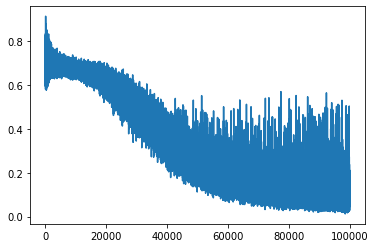

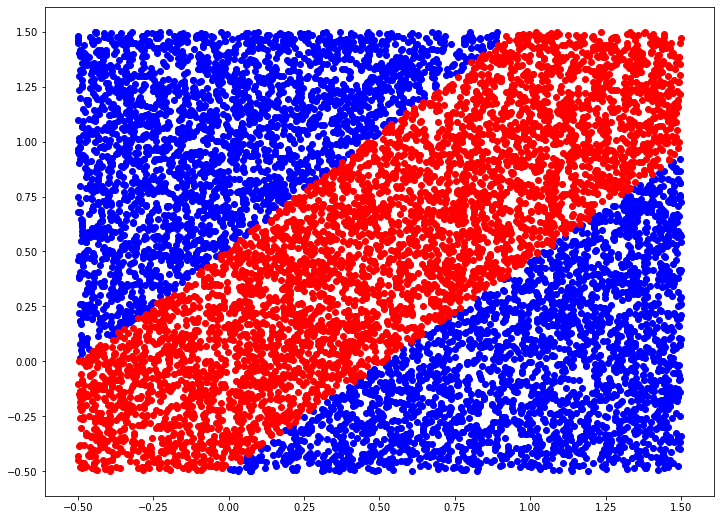

In [16]:
# Use another binary cross entropy loss  
values = train_mlp(m=3, use_cross_loss=True, iters =100000, batch_size=10, lr=0.001, X=X, y=y)
plot_boundary(values)

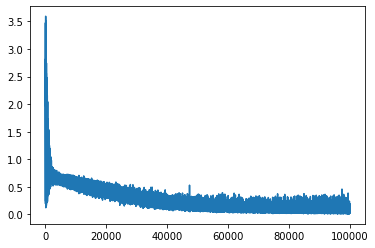

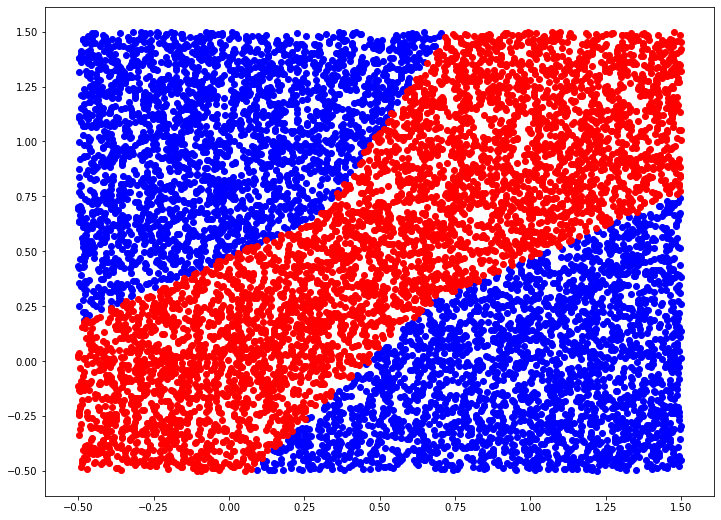

In [17]:
# Binary cross entropy loss with 16 neurons 
values = train_mlp(m=16, use_cross_loss=True, iters =100000, batch_size=10, lr=0.001, X=X, y=y)
plot_boundary(values)

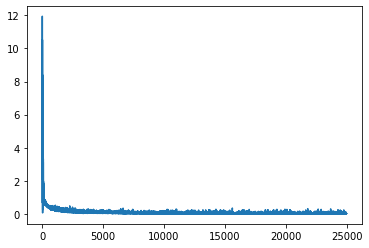

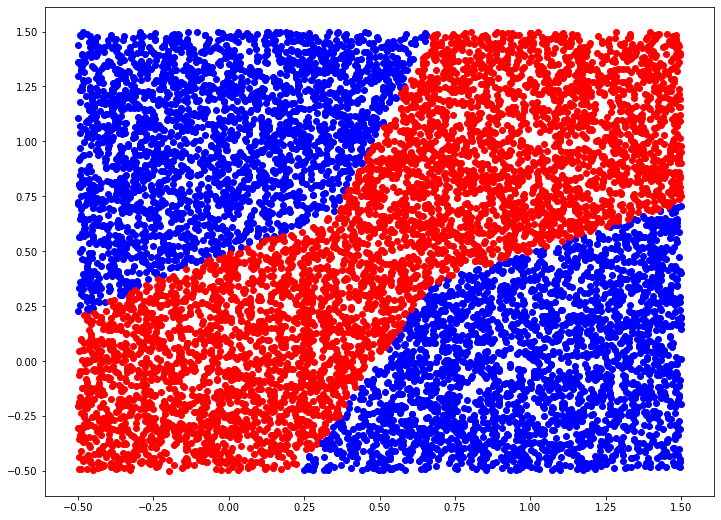

In [26]:
# Binary cross entropy loss with 512 neurons
values = train_mlp(m=512, use_cross_loss=True, iters=25000, batch_size=10, lr=0.01, X=X, y=y)
plot_boundary(values)

The three plots above show the decision boundaries determined by the network using 3, 16 and 512 neurons with a binary cross entropy loss, as opposed to a softplus loss. Similar to the results shown for the softplus loss, having 3 neurons results in decision boundaries which are somewhat accurate (i.e. they are completley linear and separate the feature space somewhat accurately) however, the network with 16 neurons shows in increase an accuracy compared to 3 neurons, by displaying boundaries which curve to split the feature space. The network with 512 neurons again, does not shown a significant improvement over the network with 16 neurons. Furthermore, while this may be an implementation issue, by using the binary cross entropy loss, the calculation for the loss and corresponding gradient sometimes result in very small values. For this reason, a smoothing term of 0.000001 is added to the partial_derivative_wrt_z term, ensuring that the value doesn't become too small, resulting in log or divide by 0 errors. It seems that the binary cross entropy loss performs slightly worse than softplus loss and it may partly be for this reason.

#### Part F: XOR with three dimensions

In [20]:
# part F
data_set_2 = pd.DataFrame(np.zeros((6000, 4)), columns=['x1', 'x2', 'x3', 'y'])

# XOR data with third dimension
for i in range(len(data_set_2.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    x3 = 1.0 * random.randint(0,1)
    if np.logical_and(np.logical_and(x1, x2), x3) or np.logical_and(np.logical_and(x1==0, x2==0), x3==0):
        y_2 = 0.0
    elif np.logical_xor(np.logical_xor(x1, x2)==1, x3==1) or np.logical_xor(np.logical_xor(x1, x2)==0, x3==0):
        y_2 = 1.0
    else:
        y_2 = 0.0
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    x3 = x3 + 0.15 * np.random.normal()
    data_set_2.iloc[i,0] = x1
    data_set_2.iloc[i,1] = x2
    data_set_2.iloc[i,2] = x3
    data_set_2.iloc[i,3] = y_2

# Split data into training and testing
train_test_split_per = 0.8

rand_rows = np.random.rand(len(data_set_2)) < train_test_split_per
train = data_set_2[rand_rows]
test = data_set_2[~rand_rows]

cols = data_set_2.shape[1]
X_2 = np.array(train.iloc[:,0:cols-1].values)
y_2 = np.array(train.iloc[:,cols-1:cols].values)

X_valid = np.array(test.iloc[:,0:cols-1].values)
y_valid = np.array(test.iloc[:,cols-1:cols].values)
data_set_2.head()

In [21]:
def test_model(values, X_valid, y_valid):
    W = values['W']
    w = values['w']
    b = values['b']
    c = values['c']
    accuracy = 0
    for i in range(len(X_valid)):
        data_point = np.array([X_valid[i]])
        u_2 = get_first_layer_output(W, data_point.T, c)
        h = get_hidden_layer_output(u_2)
        z = get_last_layer_output(w, h, b)
        
        sig = 1/(1 + np.exp(-1*z))
        if sig >= 0.5 and y_valid[i] == 1.0:
            accuracy = accuracy + 1
        if sig < 0.5 and y_valid[i] == 0.0:
            accuracy = accuracy + 1
    return accuracy/len(X_valid)

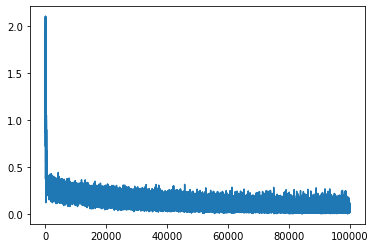

0.9723577235772358

In [22]:
# Get weights
values = train_mlp(m=16, use_cross_loss=False, iters=100000, batch_size=10, lr=0.001, dim=3, X=X_2, y=y_2)
# Find accuracy using the trained model
accuracy = test_model(values, X_valid, y_valid)
accuracy

The above shows the accuracy calculated for the train/test data split using 3D data. 16 neurons are used in the network based on the performance of the network with a hidden layer of 16 units seen in d and e.